# Transfer learning with small and different data

# Image Classification of MNIST using VGG16

When your dataset is small and very different from the original dataset used to train the pre-trained model, you can still leverage transfer learning effectively. Here's how you can employ transfer learning in this scenario:

1. **Feature Extraction**: Use the pre-trained model as a feature extractor. Remove the top layers of the pre-trained model and use the remaining layers to extract features from your dataset. Then, train a new classifier (or any other model) using these extracted features.

2. **Fine-tuning**: Fine-tune the pre-trained model on your dataset. While freezing the early layers (which capture general features like curves and edges), retrain the later layers (which capture more specific features) of the pre-trained model using your dataset. This approach allows the model to adapt to the specific characteristics of your dataset while leveraging the general knowledge learned from the original dataset.

3. **Data Augmentation**: Augment your small dataset with additional synthetic data. Apply transformations such as rotation, scaling, flipping, and translation to generate new training samples. This increases the diversity of your dataset and helps the model generalize better.

4. **Regularization**: Regularize the model to prevent overfitting on the small dataset. Techniques such as dropout, weight regularization, and early stopping can help improve the generalization performance of the model.




In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from skimage.transform import resize
import numpy as np


##Define constants


In [ ]:
TRAIN_SIZE = 400
TEST_SIZE = 100
EPOCHS = 50

## Loading and processing data to make it compitable with VGG16

In [ ]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_idx = np.random.randint(train_images.shape[0], size=TRAIN_SIZE)
test_idx = np.random.randint(test_images.shape[0], size=TEST_SIZE)


train_images = train_images[train_idx]
train_labels = train_labels[train_idx]
test_images = test_images[test_idx]
test_labels = test_labels[test_idx]


print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(500, 28, 28)
(500,)
(100, 28, 28)
(100,)


## One hot encoding labels

In [ ]:
train_labels_encoded = tf.keras.utils.to_categorical(train_labels, num_classes=10)
test_labels_encoded  = tf.keras.utils.to_categorical(test_labels, num_classes=10)

print(train_labels_encoded.shape)
print(test_labels_encoded.shape)

(500, 10)
(100, 10)


As MNIST datasets is black and white dataset it has only one dimnetion but the VGG accepts picture with 3 dimentions. This code convert the mnist images to 3 dimention image by repeating the single-channel picture 3 times.

If your picture dataset is colorful picture skip this part

In [ ]:
train_images = np.expand_dims(train_images, axis=-1)
test_images = np.expand_dims(test_images, axis=-1)

train_images = np.repeat(train_images, 3, axis=-1)
test_images = np.repeat(test_images, 3, axis=-1)

### Resizing the images
We resize the pictures to convert images to the size that VVG accept pictures.

In [ ]:
train_images = np.array([resize(image, (32, 32)) for image in train_images])

test_images = np.array([resize(image, (32, 32)) for image in test_images])

## Create tthe model

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dense(100, activation='relu'),
    Dense(10, activation='softmax')
])


early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3, verbose=0, mode='auto', start_from_epoch=20);

model.summary()

58889256/58889256 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dense_1 (Dense)             (None, 100)               51300     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 15029654 (57.33 MB)
Trainable params: 314966 (1.20 MB)
Non-trainable params: 14714688 (56.13 MB)
____________

In [ ]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])


## Train the model

In [ ]:
history = model.fit(train_images, train_labels_encoded, epochs=EPOCHS, callbacks = [early_stopping],  validation_data=(test_images, test_labels_encoded))

Epoch 1/50
16/16 [==============================] - 10s 539ms/step - loss: 1.9145 - accuracy: 0.3880 - val_loss: 1.4331 - val_accuracy: 0.5400
Epoch 2/50
16/16 [==============================] - 7s 421ms/step - loss: 1.2778 - accuracy: 0.6000 - val_loss: 1.0159 - val_accuracy: 0.7000
Epoch 3/50
16/16 [==============================] - 8s 466ms/step - loss: 0.9097 - accuracy: 0.7280 - val_loss: 0.7939 - val_accuracy: 0.7800
Epoch 4/50
16/16 [==============================] - 7s 476ms/step - loss: 0.7179 - accuracy: 0.7960 - val_loss: 0.6552 - val_accuracy: 0.8100
Epoch 5/50
16/16 [==============================] - 7s 422ms/step - loss: 0.5678 - accuracy: 0.8300 - val_loss: 0.6518 - val_accuracy: 0.8000
Epoch 6/50
16/16 [==============================] - 13s 851ms/step - loss: 0.5245 - accuracy: 0.8360 - val_loss: 0.5596 - val_accuracy: 0.8100
Epoch 7/50
16/16 [==============================] - 9s 554ms/step - loss: 0.4489 - accuracy: 0.8820 - val_loss: 0.4972 - val_accuracy: 0.8500
Epoc

### Plot the validation and accuaracy

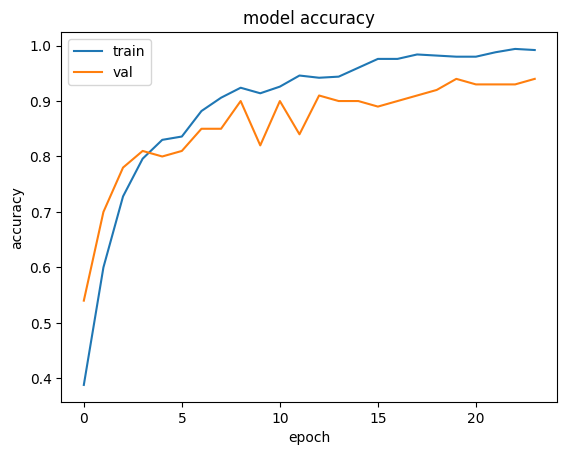

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

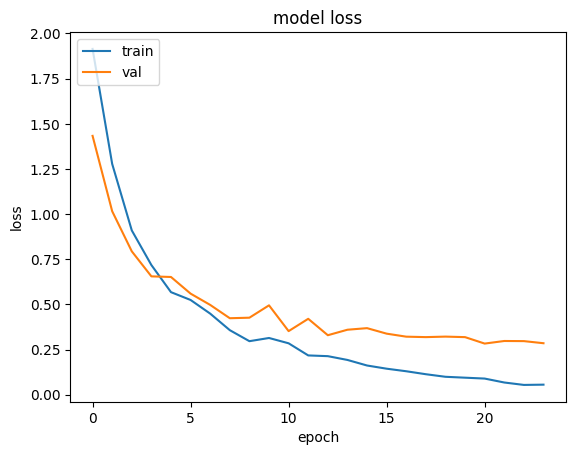

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

When your dataset is small and **similar** to the original dataset, you may not need to update the later layers of the pre-trained model. Instead, you can follow a simpler approach by only performing feature extraction and adding new classification layers on top.

1. **Feature Extraction**: Utilize the pre-trained model as a feature extractor by removing the top layers that are specific to the original task. Retain the lower layers that capture general features. Then, add new classification layers on top and train them on your small dataset. Since your dataset is similar to the original dataset, the lower layers of the pre-trained model should already have learned relevant features that are useful for your task.


2. **Freeze Pre-trained Layers**: Keep the weights of the pre-trained layers frozen during training to prevent them from being updated. By freezing the pre-trained layers, you ensure that the learned representations are preserved and not overwritten by the small dataset.


3. **Training New Classification Layers**: Train only the newly added classification layers on your small dataset. These layers learn to map the features extracted by the pre-trained model to the specific classes in your dataset.

## Chosen dataset

The Cifar-10 dataset consists of 32*32 pixel images categorized into 10 classes. This dataset is similar to original dataset of VGG.

In [ ]:
from tensorflow.keras.datasets import cifar10

In [ ]:
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

170498071/170498071 [==============================] - 11s 0us/step
(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [ ]:
TRAIN_SIZE = 500
TEST_SIZE = 100

We get a small sample from our dataset to make it small. (1% of our original dataset)

In [ ]:
train_idx = np.random.randint(train_images.shape[0], size=TRAIN_SIZE)
test_idx = np.random.randint(test_images.shape[0], size=TEST_SIZE)


train_images = train_images[train_idx,:]
train_labels = train_labels[train_idx,:]
test_images = test_images[test_idx,:]
test_labels = test_labels[test_idx,:]


print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(500, 32, 32, 3)
(500, 1)
(100, 32, 32, 3)
(100, 1)


### Normalize data

In [ ]:
train_images = (train_images.astype('float32') - 127.5) / 127.5
test_images = (test_images.astype('float32') - 127.5) / 127.5

### One hot encoding

In [ ]:
train_labels_encoded = tf.keras.utils.to_categorical(train_labels, num_classes=10)
test_labels_encoded  = tf.keras.utils.to_categorical(test_labels, num_classes=10)

print(train_labels_encoded.shape)
print(test_labels_encoded.shape)

(500, 10)
(100, 10)


### Create the model
What we have done for creating the model.
- using the fisrt layesr of VGG16
- adding a new classifier layer
- using early stopping and adam optimizer


In [ ]:
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

for layer in vgg_model.layers:
    layer.trainable = False

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

vgg_model = tf.keras.Sequential([
    vgg_model,
    global_average_layer,
    tf.keras.layers.Dense(10, activation='softmax')
])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3, verbose=0, mode='auto', start_from_epoch=20);

vgg_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

### Train the model

In [ ]:
vgg_history = vgg_model.fit(train_images,
                            train_labels_encoded,
                            epochs=EPOCHS,
                            validation_data=(test_images ,test_labels_encoded),
                            callbacks = [early_stopping],
                            verbose=1)

Epoch 1/50
16/16 [==============================] - 9s 549ms/step - loss: 2.4374 - accuracy: 0.1160 - val_loss: 2.2938 - val_accuracy: 0.1100
Epoch 2/50
16/16 [==============================] - 8s 513ms/step - loss: 2.1343 - accuracy: 0.2100 - val_loss: 2.0897 - val_accuracy: 0.2400
Epoch 3/50
16/16 [==============================] - 7s 416ms/step - loss: 1.9671 - accuracy: 0.2980 - val_loss: 1.9626 - val_accuracy: 0.3600
Epoch 4/50
16/16 [==============================] - 8s 500ms/step - loss: 1.8282 - accuracy: 0.4040 - val_loss: 1.8610 - val_accuracy: 0.4200
Epoch 5/50
16/16 [==============================] - 7s 450ms/step - loss: 1.7162 - accuracy: 0.4780 - val_loss: 1.7933 - val_accuracy: 0.4900
Epoch 6/50
16/16 [==============================] - 8s 502ms/step - loss: 1.6195 - accuracy: 0.5400 - val_loss: 1.7294 - val_accuracy: 0.5100
Epoch 7/50
16/16 [==============================] - 7s 426ms/step - loss: 1.5387 - accuracy: 0.5920 - val_loss: 1.6769 - val_accuracy: 0.5300
Epoch 

### Plot the loss and accuracy

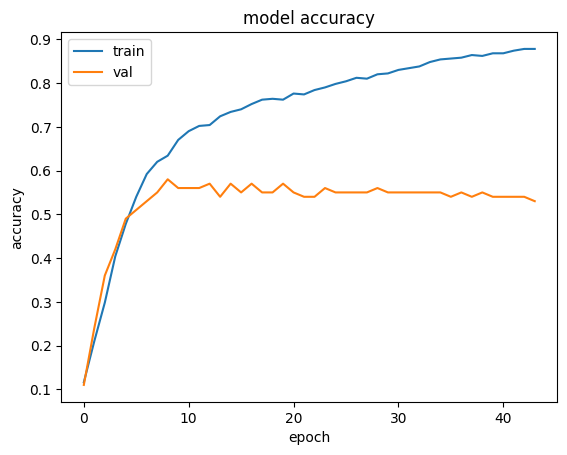

In [ ]:
import matplotlib.pyplot as plt

plt.plot(vgg_history.history['accuracy'])
plt.plot(vgg_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

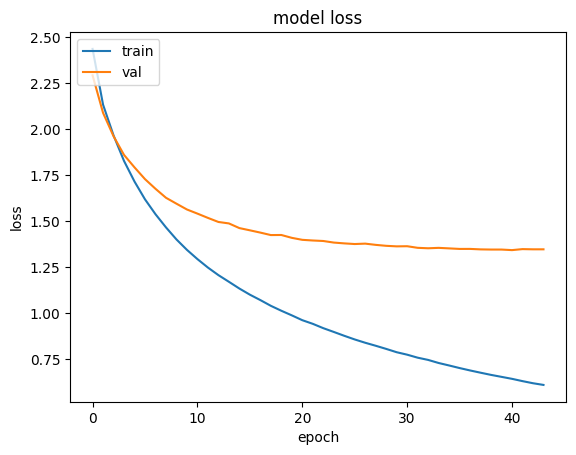

In [ ]:
plt.plot(vgg_history.history['loss'])
plt.plot(vgg_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()